#### Подключаем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

#### Путь к директориям

In [4]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

**Обзор обучающего датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [5]:
# Объеденим Train и Test

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [7]:
data = pd.concat([df_train, df_test], axis=0)
data = data.reset_index(drop=True)
data.shape

x_train = data[data["Credit Default"].notnull()]
x_test = data[data["Credit Default"].isnull()]

In [8]:
df_train.tail(n=3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7497,Rent,1878910.00,6 years,0.00,12.00,32.10,1778920.00,0.00,nan,0.00,buy a car,Short Term,99999999.00,477812.00,12479.00,748.00,0
7498,Home Mortgage,nan,NaN,0.00,21.00,26.50,1141250.00,0.00,nan,0.00,debt consolidation,Short Term,615274.00,476064.00,37118.00,nan,0
7499,Rent,nan,4 years,0.00,8.00,9.40,480832.00,0.00,nan,0.00,debt consolidation,Short Term,26928.00,288192.00,9061.00,nan,0


In [9]:
df_test.tail(n=3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2497,Home Mortgage,1171806.00,2 years,0.00,48.00,12.80,1706430.00,0.00,nan,0.00,debt consolidation,Short Term,430496.00,676438.00,36912.00,695.00
2498,Rent,723520.00,10+ years,0.00,14.00,28.80,945780.00,0.00,nan,0.00,debt consolidation,Short Term,257774.00,391248.00,13506.00,744.00
2499,Rent,1694439.00,10+ years,0.00,12.00,18.40,1199748.00,1.00,72.00,0.00,debt consolidation,Long Term,763004.00,559531.00,23440.00,6820.00


In [10]:
df_train.shape[1]-1 == df_test.shape[1]

True

#### Приведение типов

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [12]:
df_train.dtypes.value_counts()

float64    12
object      4
int64       1
dtype: int64

In [13]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,5943.00,7500.00
mean,1366391.72,0.03,11.13,18.32,945153.73,0.17,34.69,0.12,11873177.45,289833.24,18314.45,1151.09,0.28
std,845339.20,0.27,4.91,7.04,16026216.67,0.50,21.69,0.35,31926122.97,317871.38,11926.76,1604.45,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00,0.00
25%,844341.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,180169.00,114256.50,10067.50,711.00,0.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00,0.00
75%,1640137.00,0.00,14.00,21.80,793501.50,0.00,50.00,0.00,519882.00,360406.25,23818.00,743.00,1.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00,1.00


In [14]:
# По максимальным и минимальным значениям видим ярко выраженные выбросы в некоторых категориях, а так же пропуски в строках.

#### Обработка пропусков

In [15]:
df_train.isnull().sum(axis=0)

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [16]:
# Заполним пропуски медианой и сделаем проверку

In [17]:
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train['Annual Income'].median()

In [18]:
df_train['Annual Income'].isnull().sum()

0

In [19]:
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_train['Months since last delinquent'].median()

In [20]:
df_train['Months since last delinquent'].isnull().sum()

0

In [21]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].median()

In [22]:
df_train['Bankruptcies'].isnull().sum()

0

In [23]:
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = df_train['Credit Score'].median()

In [24]:
df_train['Credit Score'].isnull().sum()

0

In [25]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] == 'No Value'

In [26]:
df_train['Years in current job'].isnull().sum()

0

#### Обработка выбросов

In [27]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1325285.73,0.03,11.13,18.32,945153.73,0.17,33.23,0.12,11873177.45,289833.24,18314.45,1063.88,0.28
std,756755.14,0.27,4.91,7.04,16026216.67,0.50,14.70,0.35,31926122.97,317871.38,11926.76,1438.34,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00,0.00
25%,931133.00,0.00,8.00,13.50,279229.50,0.00,32.00,0.00,180169.00,114256.50,10067.50,718.00,0.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00,0.00
75%,1499974.00,0.00,14.00,21.80,793501.50,0.00,32.00,0.00,519882.00,360406.25,23818.00,740.00,1.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00,1.00


In [28]:
# Видим явный выброс в Credit Score. Большой разрыв между 75% и Max. Выведем строки с показателем больше 1000 и разделим на 10

In [29]:
df_train[df_train['Credit Score'] > 1000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.00,2 years,0.00,12.00,17.50,700062.00,0.00,21.00,0.00,other,Long Term,525998.00,174135.00,9320.00,6470.00,1
87,Home Mortgage,1533566.00,7 years,0.00,11.00,14.80,715462.00,0.00,19.00,0.00,debt consolidation,Short Term,210826.00,285475.00,18147.00,7440.00,1
94,Rent,1049294.00,3 years,0.00,5.00,6.10,249810.00,0.00,32.00,0.00,business loan,Short Term,337502.00,119529.00,15215.00,7010.00,1
96,Rent,757568.00,5 years,0.00,13.00,11.40,383548.00,0.00,32.00,0.00,debt consolidation,Short Term,210518.00,276583.00,11553.00,7320.00,1
116,Home Mortgage,1039984.00,False,0.00,10.00,23.80,147950.00,0.00,63.00,0.00,debt consolidation,Short Term,224246.00,95456.00,13780.00,7390.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,Rent,694868.00,1 year,0.00,4.00,7.80,143066.00,0.00,32.00,0.00,debt consolidation,Long Term,244178.00,122075.00,4268.00,6690.00,1
7433,Rent,2011758.00,< 1 year,0.00,4.00,14.90,22176.00,0.00,43.00,0.00,buy a car,Long Term,106480.00,18791.00,12590.00,6060.00,1
7450,Home Mortgage,1432277.00,10+ years,0.00,16.00,22.80,825176.00,0.00,32.00,0.00,debt consolidation,Short Term,187924.00,458242.00,27094.00,7290.00,1
7460,Rent,769462.00,5 years,0.00,8.00,17.00,313786.00,0.00,80.00,0.00,debt consolidation,Short Term,109186.00,45524.00,4585.00,7470.00,1


In [30]:
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] / 10

In [31]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1325285.73,0.03,11.13,18.32,945153.73,0.17,33.23,0.12,11873177.45,289833.24,18314.45,722.35,0.28
std,756755.14,0.27,4.91,7.04,16026216.67,0.50,14.70,0.35,31926122.97,317871.38,11926.76,25.28,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00,0.00
25%,931133.00,0.00,8.00,13.50,279229.50,0.00,32.00,0.00,180169.00,114256.50,10067.50,715.00,0.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00,0.00
75%,1499974.00,0.00,14.00,21.80,793501.50,0.00,32.00,0.00,519882.00,360406.25,23818.00,738.00,1.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,751.00,1.00


In [32]:
# Видим странные показатели для "Current Loan Amount". Выведем строки, где текущая сумма кредита больше наибольшего открытого кредита

In [33]:
df_train[df_train['Maximum Open Credit'] < df_train['Current Loan Amount']]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,False,0.00,11.00,26.30,685960.00,1.00,32.00,1.00,debt consolidation,Short Term,99999999.00,47386.00,7914.00,749.00,0
2,Home Mortgage,751412.00,8 years,0.00,11.00,35.00,1182434.00,0.00,32.00,0.00,debt consolidation,Short Term,99999999.00,308389.00,13651.00,742.00,0
6,Home Mortgage,1511108.00,10+ years,0.00,9.00,20.30,388124.00,0.00,73.00,0.00,home improvements,Short Term,99999999.00,51623.00,2317.00,745.00,0
8,Home Mortgage,1168386.00,5 years,0.00,17.00,15.70,0.00,1.00,32.00,1.00,home improvements,Short Term,129734.00,19.00,17.00,731.00,0
9,Home Mortgage,1168386.00,1 year,0.00,10.00,24.60,511302.00,0.00,6.00,0.00,debt consolidation,Long Term,572880.00,205333.00,17613.00,731.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,Home Mortgage,1542952.00,10+ years,0.00,7.00,12.50,232364.00,0.00,59.00,0.00,debt consolidation,Long Term,267982.00,198873.00,15430.00,695.00,1
7488,Rent,465405.00,5 years,0.00,5.00,7.70,51744.00,0.00,33.00,0.00,home improvements,Short Term,129338.00,8721.00,13535.00,728.00,0
7491,Home Mortgage,2833185.00,6 years,0.00,18.00,21.30,280170.00,0.00,6.00,0.00,debt consolidation,Short Term,437404.00,108889.00,61150.00,704.00,0
7495,Rent,402192.00,< 1 year,0.00,3.00,8.50,107866.00,0.00,32.00,0.00,other,Short Term,129360.00,73492.00,1900.00,697.00,0


In [34]:
# Вполне логично будет приравнять сумму текущего кредита к наибольшей сумме кредита.

In [35]:
df_train.loc[df_train['Maximum Open Credit'] < df_train['Current Loan Amount'], 'Current Loan Amount'] = df_train.loc[df_train['Maximum Open Credit'] < df_train['Current Loan Amount'], 'Maximum Open Credit']



In [36]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1325285.73,0.03,11.13,18.32,945153.73,0.17,33.23,0.12,346866.65,289833.24,18314.45,722.35,0.28
std,756755.14,0.27,4.91,7.04,16026216.67,0.50,14.70,0.35,753399.38,317871.38,11926.76,25.28,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,585.00,0.00
25%,931133.00,0.00,8.00,13.50,279229.50,0.00,32.00,0.00,159846.50,114256.50,10067.50,715.00,0.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,261734.00,209323.00,16076.50,731.00,0.00
75%,1499974.00,0.00,14.00,21.80,793501.50,0.00,32.00,0.00,425975.00,360406.25,23818.00,738.00,1.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,40923894.00,6506797.00,136679.00,751.00,1.00


#### Анализ данных

In [37]:
# Выделим целевую переменную и построим ее распределение в виде графика

In [38]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

In [39]:
df_train[TARGET_NAME].value_counts(normalize=True)

0   0.72
1   0.28
Name: Credit Default, dtype: float64

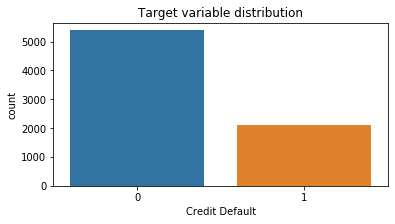

In [40]:
plt.figure(figsize=(6, 3))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

In [41]:
# По графику видно, что целевая переменная не имеет сильного дизбаланса

In [42]:
# Проверим корреляцию с базовыми признаками

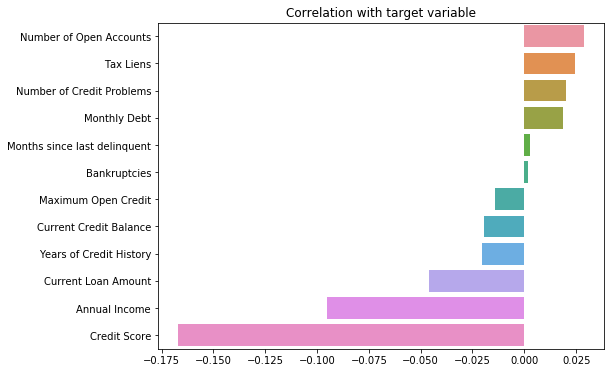

In [43]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [44]:
# Видим, что Credit Score и Annual Income являются наиболее важными показателеми, что вполне соответствует действительности.

#### Отбор признаков

In [45]:
df_train.shape

(7500, 17)

In [46]:
df_test.shape

(2500, 16)

In [47]:
df_train.select_dtypes(include='object').columns.tolist()

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [48]:
df_train.select_dtypes(exclude='object').columns.tolist()

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [49]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                     'Credit Score']

In [50]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [51]:
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [52]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

#### Приведение типов для модели CatBoost

In [53]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

#### Нормализация данных

#### Train и Test

In [54]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [55]:
y_train.mean(), y_test.mean()

(0.2817142857142857, 0.2817777777777778)

#### Балансировка целевой переменной

In [56]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [57]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts(normalize=True)

0   0.56
1   0.44
Name: Credit Default, dtype: float64

#### Сохраним датасеты

In [58]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

#### Построение и оценка моделей

In [59]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

#### CatBoost

In [60]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3771
           1       0.98      0.37      0.53      1479

    accuracy                           0.82      5250
   macro avg       0.89      0.68      0.71      5250
weighted avg       0.85      0.82      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1616
           1       0.51      0.11      0.19       634

    accuracy                           0.72      2250
   macro avg       0.62      0.54      0.51      2250
weighted avg       0.67      0.72      0.65      2250

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1546  70
1                562  72


#### Выбор наилучшей модели, настройка гиперпараметров

In [61]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

In [62]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [63]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [64]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 3.57 s, sys: 305 ms, total: 3.87 s
Wall time: 1min 31s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fc6cf1cdb90>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [65]:
rs.best_params_

{'n_estimators': 500, 'max_depth': 3}

In [66]:
rs.best_score_

0.48787863236213624

#### Обучение финальной модели

In [67]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.99      0.85      3771
           1       0.87      0.13      0.22      1479

    accuracy                           0.75      5250
   macro avg       0.81      0.56      0.54      5250
weighted avg       0.78      0.75      0.67      5250

TEST

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1616
           1       0.66      0.07      0.13       634

    accuracy                           0.73      2250
   macro avg       0.69      0.53      0.48      2250
weighted avg       0.71      0.73      0.64      2250

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1593  23
1                590  44
CPU times: user 2.65 s, sys: 136 ms, total: 2.79 s
Wall time: 1.38 s


#### Снижение степени переобучения

In [68]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.99      0.84      3771
           1       0.83      0.09      0.16      1479

    accuracy                           0.74      5250
   macro avg       0.78      0.54      0.50      5250
weighted avg       0.76      0.74      0.65      5250

TEST

              precision    recall  f1-score   support

           0       0.72      0.99      0.84      1616
           1       0.61      0.04      0.07       634

    accuracy                           0.72      2250
   macro avg       0.67      0.51      0.46      2250
weighted avg       0.69      0.72      0.62      2250

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1600  16
1                609  25


#### Важность признаков

In [69]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.6))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

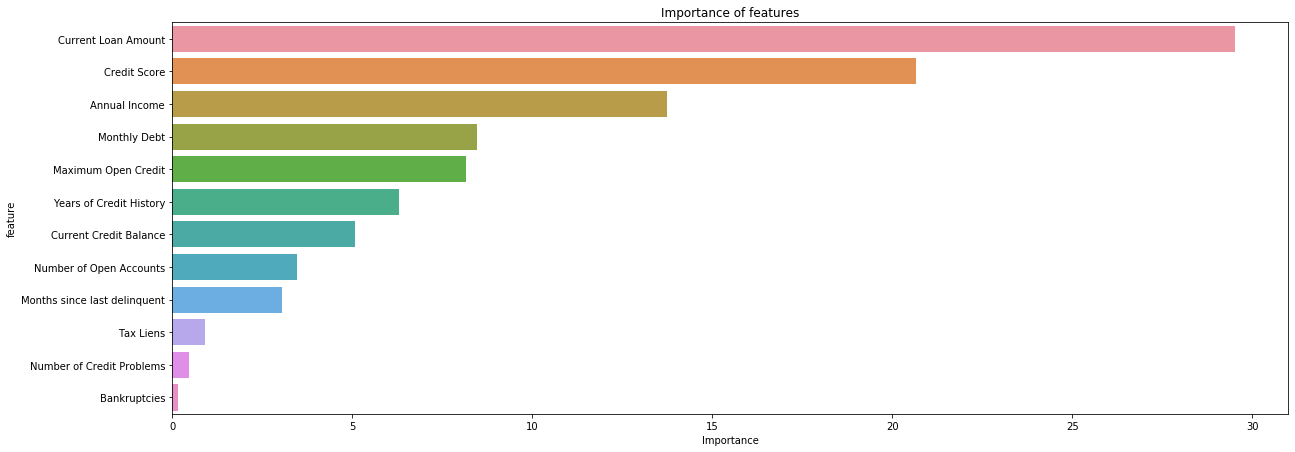

In [70]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)